In [1]:
# Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip uninstall --yes anything

In [57]:
%matplotlib inline

import pyspark
from pyspark.sql.functions import udf, col, rand
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D 

In [42]:
df.head()

Row(_c0='0', Year='2008', Month='1', DayofMonth='3', DayOfWeek='4', DepTime='2003.0', CRSDepTime='1955', ArrTime='2211.0', CRSArrTime='2225', UniqueCarrier='WN', FlightNum='335', TailNum='N712SW', ActualElapsedTime='128.0', CRSElapsedTime='150.0', AirTime='116.0', ArrDelay='-14.0', DepDelay='8.0', Origin='IAD', Dest='TPA', Distance='810', TaxiIn='4.0', TaxiOut='8.0', Cancelled='0', CancellationCode='N', Diverted='0', CarrierDelay=None, WeatherDelay=None, NASDelay=None, SecurityDelay=None, LateAircraftDelay=None)

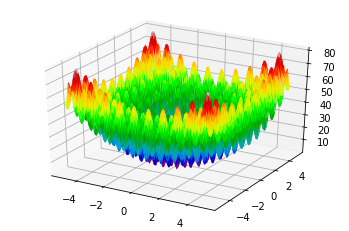

In [22]:
X = np.linspace(-5.12, 5.12, 100)     
Y = np.linspace(-5.12, 5.12, 100)     
X, Y = np.meshgrid(X, Y)

Z = (X**2 - 10 * np.cos(2 * np.pi * X)) + \
  (Y**2 - 10 * np.cos(2 * np.pi * Y)) + 20
        
    
fig = plt.figure() 
ax = fig.gca(projection='3d') 
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
  cmap=cm.nipy_spectral, linewidth=0.08,
  antialiased=True)
# plt.savefig('rastrigin_graph.png')
plt.show()

In [4]:
# Reading dataset from CSV
df = (spark.read
    .option("header", "true")
    .option("mode", "DROPMALFORMED")
    .csv("airlinedelaycauses/DelayedFlights.csv"))

df.count()

1936758

In [113]:
df.groupBy("Cancelled").count().orderBy("Cancelled").show()

+---------+-------+
|Cancelled|  count|
+---------+-------+
|        0|1936125|
|        1|    633|
+---------+-------+



In [97]:
# Printing shape of dataset
print((df.count(), len(df.columns)))
df.head()

(1936758, 30)


Row(_c0='0', Year='2008', Month='1', DayofMonth='3', DayOfWeek='4', DepTime='2003.0', CRSDepTime='1955', ArrTime='2211.0', CRSArrTime='2225', UniqueCarrier='WN', FlightNum='335', TailNum='N712SW', ActualElapsedTime='128.0', CRSElapsedTime='150.0', AirTime='116.0', ArrDelay='-14.0', DepDelay='8.0', Origin='IAD', Dest='TPA', Distance='810', TaxiIn='4.0', TaxiOut='8.0', Cancelled='0', CancellationCode='N', Diverted='0', CarrierDelay=None, WeatherDelay=None, NASDelay=None, SecurityDelay=None, LateAircraftDelay=None)

In [99]:
df.describe()

DataFrame[summary: string, _c0: string, Year: string, Month: string, DayofMonth: string, DayOfWeek: string, DepTime: string, CRSDepTime: string, ArrTime: string, CRSArrTime: string, UniqueCarrier: string, FlightNum: string, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: string, TaxiIn: string, TaxiOut: string, Cancelled: string, CancellationCode: string, Diverted: string, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string]

In [93]:
# Slicing 1000 random values
df1 = df.orderBy(rand()).limit(1000) # highly inefficient

# Selecting features to work on
columns_to_scale = ["DepTime", "ArrTime"]

# Filter selected features
df1 = df1.select(*columns_to_scale)

# Filter out nulls
df1.filter(df1.DepTime.isNotNull())
df1.filter(df1.ArrTime.isNotNull())

# Convert to integer
df1 = df1.withColumn("DepTime", col("DepTime").cast(IntegerType()))
df1 = df1.withColumn("ArrTime", col("ArrTime").cast(IntegerType()))

# Vectorize & Scale data for ABC
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec", handleInvalid = "skip") for col in columns_to_scale]
scalers = [MinMaxScaler(min=-5.12, max=5.12, inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]

# Creating pipeline stages
pipeline = Pipeline(stages=assemblers + scalers)

#Running pipeline
scalerModel = pipeline.fit(df1)
scaledData = scalerModel.transform(df1)

scaledData.show()

+-------+-------+-----------+-----------+--------------------+--------------------+
|DepTime|ArrTime|DepTime_vec|ArrTime_vec|      DepTime_scaled|      ArrTime_scaled|
+-------+-------+-----------+-----------+--------------------+--------------------+
|   1737|   1834|   [1737.0]|   [1834.0]| [2.437887563884157]|[2.8434789987271962]|
|   2050|   2139|   [2050.0]|   [2139.0]|[3.8029301533219764]| [4.168553245651252]|
|     48|    230|     [48.0]|    [230.0]|[-4.928109028960818]|[-4.125108188375053]|
|   2043|   2157|   [2043.0]|   [2157.0]| [3.772402044293016]|  [4.24675434874841]|
|    815|   1248|    [815.0]|   [1248.0]|[-1.5831005110732...|[0.29759864234196...|
|    906|   1025|    [906.0]|   [1025.0]|[-1.1862350936967...|[-0.6712261349172...|
|   1935|   2057|   [1935.0]|   [2057.0]|[3.3013969335604783]|[3.8123037759864244]|
|   1305|   1413|   [1305.0]|   [1413.0]|[0.5538671209540036]| [1.014442087399237]|
|   1950|   2226|   [1950.0]|   [2226.0]| [3.366814310051109]|[4.54652524395

In [94]:
# Reverse vectorization
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, DoubleType

def to_array(col):
    def to_array_(v):
        return v.toArray().tolist()
    # Important: asNondeterministic requires Spark 2.3 or later
    # It can be safely removed i.e.
    # return udf(to_array_, ArrayType(DoubleType()))(col)
    # but at the cost of decreased performance
    return udf(to_array_, ArrayType(DoubleType())).asNondeterministic()(col)


scaledData = scaledData \
.withColumn("DepTime", to_array(col("DepTime_scaled"))) \
.withColumn("ArrTime", to_array(col("ArrTime_scaled"))).select([col("ArrTime")[0]] + [col("DepTime")[0]])

scaledData.show()

+-------------------+-------------------+
|         ArrTime[0]|         DepTime[0]|
+-------------------+-------------------+
| 2.8434789987271962|  2.437887563884157|
|  4.168553245651252| 3.8029301533219764|
| -4.125108188375053| -4.928109028960818|
|   4.24675434874841|  3.772402044293016|
|0.29759864234196076|-1.5831005110732534|
|-0.6712261349172675|-1.1862350936967627|
| 3.8123037759864244| 3.3013969335604783|
|  1.014442087399237| 0.5538671209540036|
| 4.5465252439541795|  3.366814310051109|
|-0.7277047093763258|-1.5656558773424187|
| 1.1404327535002121|  0.170085178875639|
| 3.2475180313958427| 0.6367291311754686|
|  4.029529062367417|  2.778057921635435|
| 1.4923377174374206|0.27039182282793917|
| 1.1273992363173528| 0.6454514480408866|
| 1.5531607976240993| 0.6977853492333903|
|  4.594314806957999|  4.116933560477002|
|-0.7407382265591851|-1.8578534923339007|
|0.22374204497242278|-0.6323679727427596|
| -4.663826898599916|  4.618466780238502|
+-------------------+-------------

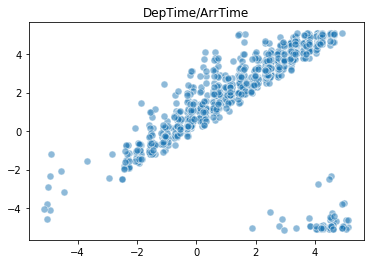

In [112]:
pdf = scaledData.toPandas()
plt.scatter(pdf["DepTime[0]"], pdf["ArrTime[0]"], s=50, edgecolor='w', alpha=0.5)
plt.title('DepTime/ArrTime')
plt.show()

In [138]:
objective_function = Rastrigin(dim=1000)
optimizer = ABC(obj_function=objective_function, colony_size=30,
                n_iter=300, max_trials=100)
optimizer.optimize()

iter: 0 = cost: 1.786e+04
iter: 1 = cost: 1.786e+04
iter: 2 = cost: 1.786e+04
iter: 3 = cost: 1.786e+04
iter: 4 = cost: 1.786e+04
iter: 5 = cost: 1.786e+04
iter: 6 = cost: 1.786e+04
iter: 7 = cost: 1.786e+04
iter: 8 = cost: 1.786e+04
iter: 9 = cost: 1.786e+04
iter: 10 = cost: 1.786e+04
iter: 11 = cost: 1.786e+04
iter: 12 = cost: 1.786e+04
iter: 13 = cost: 1.786e+04
iter: 14 = cost: 1.786e+04
iter: 15 = cost: 1.786e+04
iter: 16 = cost: 1.786e+04
iter: 17 = cost: 1.786e+04
iter: 18 = cost: 1.786e+04
iter: 19 = cost: 1.786e+04
iter: 20 = cost: 1.786e+04
iter: 21 = cost: 1.786e+04
iter: 22 = cost: 1.786e+04
iter: 23 = cost: 1.786e+04
iter: 24 = cost: 1.786e+04
iter: 25 = cost: 1.786e+04
iter: 26 = cost: 1.786e+04
iter: 27 = cost: 1.786e+04
iter: 28 = cost: 1.786e+04
iter: 29 = cost: 1.786e+04
iter: 30 = cost: 1.786e+04
iter: 31 = cost: 1.786e+04
iter: 32 = cost: 1.786e+04
iter: 33 = cost: 1.786e+04
iter: 34 = cost: 1.786e+04
iter: 35 = cost: 1.786e+04
iter: 36 = cost: 1.786e+04
iter: 37 = 

In [119]:
import numpy as np

from scipy import optimize

from abc import ABCMeta
from abc import abstractmethod
from six import add_metaclass


@add_metaclass(ABCMeta)
class ObjectiveFunction(object):

    def __init__(self, name, dim, minf, maxf):
        self.name = name
        self.dim = dim
        self.minf = minf
        self.maxf = maxf

    def sample(self):
        return np.random.uniform(low=self.minf, high=self.maxf, size=self.dim)

    def custom_sample(self):
        return np.repeat(self.minf, repeats=self.dim) \
               + np.random.uniform(low=0, high=1, size=self.dim) *\
               np.repeat(self.maxf - self.minf, repeats=self.dim)

    @abstractmethod
    def evaluate(self, x):
        pass


class Sphere(ObjectiveFunction):

    def __init__(self, dim):
        super(Sphere, self).__init__('Sphere', dim, -100.0, 100.0)

    def evaluate(self, x):
        return sum(np.power(x, 2))


class Rosenbrock(ObjectiveFunction):

    def __init__(self, dim):
        super(Rosenbrock, self).__init__('Rosenbrock', dim, -30.0, 30.0)

    def evaluate(self, x):
        return optimize.rosen(x)


class Rastrigin(ObjectiveFunction):

    def __init__(self, dim):
        super(Rastrigin, self).__init__('Rastrigin', dim, -5.12, 5.12)

    def evaluate(self, x):
        return 10 * len(x)\
               + np.sum(np.power(x, 2) - 10 * np.cos(2 * np.pi * np.array(x)))

In [120]:
class PartitionalClusteringObjectiveFunction(ObjectiveFunction):

    def __init__(self, dim, n_clusters, data):
        super(PartitionalClusteringObjectiveFunction, self)\
            .__init__('PartitionalClusteringObjectiveFunction', dim, 0.0, 1.0)
        self.n_clusters = n_clusters
        self.centroids = {}
        self.data = data

    def decode(self, x):
        centroids = x.reshape(self.n_clusters, self.dim)
        self.centroids = dict(enumerate(centroids))

    @abstractmethod
    def evaluate(self, x):
        pass
     
class SumOfSquaredErrors(PartitionalClusteringObjectiveFunction):

    def __init__(self, dim, n_clusters, data):
        super(SumOfSquaredErrors, self).__init__(dim, n_clusters, data)
        self.name = 'SumOfSquaredErrors'

    def evaluate(self, x):
        self.decode(x)

        clusters = {key: [] for key in self.centroids.keys()}
        for instance in self.data:
            distances = [np.linalg.norm(self.centroids[idx] - instance)
                         for idx in self.centroids]
            clusters[np.argmin(distances)].append(instance)

        sum_of_squared_errors = 0.0
        for idx in self.centroids:
            distances = [np.linalg.norm(self.centroids[idx] - instance)
                         for instance in clusters[idx]]
            sum_of_squared_errors += sum(np.power(distances, 2))
        return sum_of_squared_errors

In [121]:
import numpy as np

from copy import deepcopy
from abc import ABCMeta
from six import add_metaclass


@add_metaclass(ABCMeta)
class ArtificialBee(object):

    TRIAL_INITIAL_DEFAULT_VALUE = 0
    INITIAL_DEFAULT_PROBABILITY = 0.0

    def __init__(self, obj_function):
        self.pos = obj_function.custom_sample()
        self.obj_function = obj_function
        self.minf = obj_function.minf
        self.maxf = obj_function.maxf
        self.fitness = obj_function.evaluate(self.pos)
        self.trial = ArtificialBee.TRIAL_INITIAL_DEFAULT_VALUE
        self.prob = ArtificialBee.INITIAL_DEFAULT_PROBABILITY

    def evaluate_boundaries(self, pos):
        if (pos < self.minf).any() or (pos > self.maxf).any():
            pos[pos > self.maxf] = self.maxf
            pos[pos < self.minf] = self.minf
        return pos

    def update_bee(self, pos, fitness):
        if fitness <= self.fitness:
            self.pos = pos
            self.fitness = fitness
            self.trial = 0
        else:
            self.trial += 1

    def reset_bee(self, max_trials):
        if self.trial >= max_trials:
            self.__reset_bee()

    def __reset_bee(self):
        self.pos = self.obj_function.custom_sample()
        self.fitness = self.obj_function.evaluate(self.pos)
        self.trial = ArtificialBee.TRIAL_INITIAL_DEFAULT_VALUE
        self.prob = ArtificialBee.INITIAL_DEFAULT_PROBABILITY

In [122]:
class EmployeeBee(ArtificialBee):

    def explore(self, max_trials):
        if self.trial <= max_trials:
            component = np.random.choice(self.pos)
            phi = np.random.uniform(low=-1, high=1, size=len(self.pos))
            n_pos = self.pos + (self.pos - component) * phi
            n_pos = self.evaluate_boundaries(n_pos)
            n_fitness = self.obj_function.evaluate(n_pos)
            self.update_bee(n_pos, n_fitness)

    def get_fitness(self):
        return 1 / (1 + self.fitness) if self.fitness >= 0 else 1 + np.abs(self.fitness)

    def compute_prob(self, max_fitness):
        self.prob = self.get_fitness() / max_fitness

In [123]:
class OnLookerBee(ArtificialBee):

    def onlook(self, best_food_sources, max_trials):
        candidate = np.random.choice(best_food_sources)
        self.__exploit(candidate.pos, candidate.fitness, max_trials)

    def __exploit(self, candidate, fitness, max_trials):
        if self.trial <= max_trials:
            component = np.random.choice(candidate)
            phi = np.random.uniform(low=-1, high=1, size=len(candidate))
            n_pos = candidate + (candidate - component) * phi
            n_pos = self.evaluate_boundaries(n_pos)
            n_fitness = self.obj_function.evaluate(n_pos)

            if n_fitness <= fitness:
                self.pos = n_pos
                self.fitness = n_fitness
                self.trial = 0
            else:
                self.trial += 1

In [124]:
class ABC(object):

    def __init__(self, obj_function, colony_size=30, n_iter=5000, max_trials=100):
        self.colony_size = colony_size
        self.obj_function = obj_function

        self.n_iter = n_iter
        self.max_trials = max_trials

        self.optimal_solution = None
        self.optimality_tracking = []

    def __reset_algorithm(self):
        self.optimal_solution = None
        self.optimality_tracking = []

    def __update_optimality_tracking(self):
        self.optimality_tracking.append(self.optimal_solution.fitness)

    def __update_optimal_solution(self):
        n_optimal_solution = \
            min(self.onlokeer_bees + self.employee_bees,
                key=lambda bee: bee.fitness)
        if not self.optimal_solution:
            self.optimal_solution = deepcopy(n_optimal_solution)
        else:
            if n_optimal_solution.fitness < self.optimal_solution.fitness:
                self.optimal_solution = deepcopy(n_optimal_solution)

    def __initialize_employees(self):
        self.employee_bees = []
        for itr in range(self.colony_size // 2):
            self.employee_bees.append(EmployeeBee(self.obj_function))

    def __initialize_onlookers(self):
        self.onlokeer_bees = []
        for itr in range(self.colony_size // 2):
            self.onlokeer_bees.append(OnLookerBee(self.obj_function))

    def __employee_bees_phase(self):
        map(lambda bee: bee.explore(self.max_trials), self.employee_bees)

    def __calculate_probabilities(self):
        sum_fitness = sum(map(lambda bee: bee.get_fitness(), self.employee_bees))
        map(lambda bee: bee.compute_prob(sum_fitness), self.employee_bees)

    def __select_best_food_sources(self):
        self.best_food_sources =\
            filter(lambda bee: bee.prob > np.random.uniform(low=0, high=1),
                   self.employee_bees)
        while not self.best_food_sources:
            self.best_food_sources = \
                filter(lambda bee: bee.prob > np.random.uniform(low=0, high=1),
                       self.employee_bees)

    def __onlooker_bees_phase(self):
        map(lambda bee: bee.onlook(self.best_food_sources, self.max_trials),
            self.onlokeer_bees)

    def __scout_bees_phase(self):
        map(lambda bee: bee.reset_bee(self.max_trials),
            self.onlokeer_bees + self.employee_bees)

    def optimize(self):
        self.__reset_algorithm()
        self.__initialize_employees()
        self.__initialize_onlookers()
        for itr in range(self.n_iter):
            self.__employee_bees_phase()
            self.__update_optimal_solution()

            self.__calculate_probabilities()
            self.__select_best_food_sources()

            self.__onlooker_bees_phase()
            self.__scout_bees_phase()

            self.__update_optimal_solution()
            self.__update_optimality_tracking()
            print("iter: {} = cost: {}"
                  .format(itr, "%04.03e" % self.optimal_solution.fitness))

In [139]:
@add_metaclass(ABCMeta)
class PartitionalClusteringObjectiveFunction(ObjectiveFunction):

    def __init__(self, dim, n_clusters, data):
        super(PartitionalClusteringObjectiveFunction, self)\
            .__init__('PartitionalClusteringObjectiveFunction', dim, 0.0, 1.0)
        self.n_clusters = n_clusters
        self.centroids = {}
        self.data = data

    def decode(self, x):
        centroids = x.reshape(self.n_clusters, self.dim)
        self.centroids = dict(enumerate(centroids))

    @abstractmethod
    def evaluate(self, x):
        pass
     
class SumOfSquaredErrors(PartitionalClusteringObjectiveFunction):

    def __init__(self, dim, n_clusters, data):
        super(SumOfSquaredErrors, self).__init__(dim, n_clusters, data)
        self.name = 'SumOfSquaredErrors'

    def evaluate(self, x):
        self.decode(x)

        clusters = {key: [] for key in self.centroids.keys()}
        for instance in self.data:
            distances = [np.linalg.norm(self.centroids[idx] - instance)
                         for idx in self.centroids]
            clusters[np.argmin(distances)].append(instance)

        sum_of_squared_errors = 0.0
        for idx in self.centroids:
            distances = [np.linalg.norm(self.centroids[idx] - instance)
                         for instance in clusters[idx]]
            sum_of_squared_errors += sum(np.power(distances, 2))
        return sum_of_squared_errors

In [ ]:
objective_function = SumOfSquaredErrors(dim=1000, n_clusters=2, data=scaledData.rdd)
optimizer = ABC(obj_function=objective_function, colony_size=30,
                n_iter=300, max_trials=100)
optimizer.optimize()

def decode_centroids(centroids, n_clusters, data):
    return centroids.reshape(n_clusters, data.shape[1])
  
centroids = dict(enumerate(decode_centroids(optimizer.optimal_solution.pos,
                                            n_clusters=3, data=data)))

def assign_centroid(centroids, point):
    distances = [np.linalg.norm(point - centroids[idx]) for idx in centroids]
    return np.argmin(distances)
  
custom_tgt = []
for instance in data:
    custom_tgt.append(assign_centroid(centroids, instance))

colors = ['r', 'g', 'y']
plt.figure(figsize=(9,8))
for instance, tgt in zip(data, custom_tgt):
    plt.scatter(instance[0], instance[1], s=50, edgecolor='w',
                alpha=0.5, color=colors[tgt])

for centroid in centroids:
    plt.scatter(centroids[centroid][0], centroids[centroid][1],
                color='k', marker='x', lw=5, s=500)
plt.title('Partitioned Data found by ABC')